In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
seed = 1

lr = 0.001

epochs = 30
log_interval = 10

no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 2 * torch.cuda.device_count()
test_batch_size = 2 * torch.cuda.device_count()

torch.manual_seed(seed)

kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.pool1 = nn.MaxPool2d(2,2,ceil_mode=True)
        
        #f2
        self.conv3 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(inplace=True)

        self.pool2 = nn.MaxPool2d(2,2,ceil_mode=True)        
        
        #f3
        self.conv5 = nn.Conv2d(256, 128, 5, 1, 2)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(256, 128, 5, 1, 2)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU(inplace=True)

        self.pool3 = nn.MaxPool2d(2,2,ceil_mode=True)
        
        #f4
        self.conv7 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(32*32*512, 256)
        self.fc2 = nn.Linear(256, 32*32*256)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(256, 256, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(128)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(256, 64, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(128)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(128, 1, 5, 2, 2, 1)
        
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x)))
        f1_2 = self.relu2(self.bn2(self.conv2(x)))
        
        f1 = torch.cat((f1_1, f1_2), 1)
        f1 = self.pool1(f1)
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1)))
        f2_2 = self.relu4(self.bn4(self.conv4(f1)))
        
        f2 = torch.cat((f2_1, f2_2), 1)
        f2 = self.pool2(f2)
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2)))
        f3_2 = self.relu6(self.bn6(self.conv6(f2)))
        
        f3 = torch.cat((f3_1, f3_2), 1)
        f3 = self.pool3(f3)

        f4_1 = self.relu7(self.bn7(self.conv7(f3)))
        f4_2 = self.relu8(self.bn8(self.conv8(f3)))
        
        f4 = torch.cat((f4_1, f4_2), 1)
        x = f4.view(f4.size(0), -1)
        
        encode = self.fc1(x)
        
        d1 = self.fc2(encode)
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,32,32))))
             
        d1_uni = torch.cat((d1, f3_2), 1)
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni)))
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni)))
        
        d2_uni = torch.cat((d2, f2_2), 1)
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni)))
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni)))
        
        d3_uni = torch.cat((d3, f1_2), 1)
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni)))

        decode = self.conv15(d3_uni)
        
        return torch.sigmoid(decode)

# Preprocess

In [4]:
train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')
len(train_paths), len(test_paths), len(val_paths)

(8000, 995, 1000)

In [5]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_occlusionX_semantic/%s.png'%label_name
    label = Image.open(label_path)
    label = np.array(label)
    label = np.where(label>0,1.0,0)
    label = torch.from_numpy(label)
    label = label.view(1,512,512)
    
    return label.float()

In [6]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # Read Image
        image = Image.open(path).convert("RGB")
        
        #Get Label
        label = get_label(path)
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                #transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

In [8]:
for i, (data, target) in enumerate(train_loader):
    if i == 0:
        print(data[0].shape, target[0].shape)
        break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


# Optimization

In [9]:
model = Net()
model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           4,864
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]           4,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         409,728
       BatchNorm2d-9        [-1, 128, 128, 128]             256
        LeakyReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         409,728
      BatchNorm2d-12        [-1, 128, 128, 128]             256
        LeakyReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 256,

# Visualization

In [30]:
def visualization(model, test_path, target_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).view(1,3,512,512)
    result = model(image)
    result = result.to('cpu').detach().numpy()
    result = np.where(result[0,:,:,:]>=0.5, 1.0, 0)

    test_image = plt.imread(test_path)
    target_image = plt.imread(target_path)
    
    plt.figure(figsize=(15,15))
    display_list = [test_image, target_image, result[0,:,:]]
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

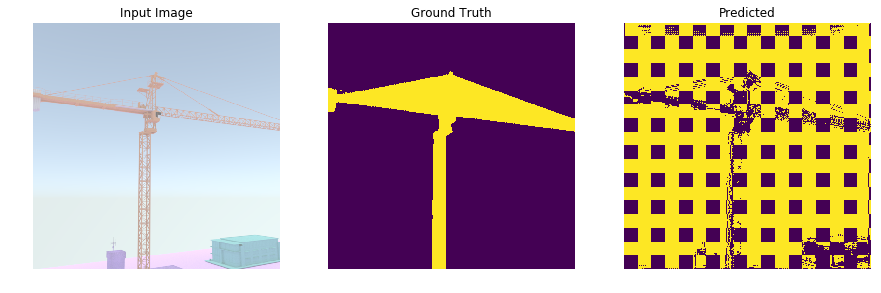

In [12]:
test_path = 'C:\\Users\\IVCL\\Desktop\\dock5_DR_800\\dataset\\test\\camera30865.png'
target_path = 'C:\\Users\\IVCL\\Desktop\\dock5_DR\\classify_occlusionX_semantic\\camera30865.png'
visualization(model, test_path, target_path)

# Training

In [13]:
checkpoint_path = './checkpoints_tc120'

In [14]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

In [15]:
loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    # Train Mode
    model.to(device).train()
    prec = 0
    rec = 0

    train_loss_sum = 0
    val_loss_sum = 0 
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        

        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss_sum = train_loss_sum + loss.item()
        
        prec += precision(target, output)
        rec += recall(target, output)
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\t\tPrecision: {:.4f}\tRecall : {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss_sum / ((batch_idx + 1e-7) * len(data)),
                100. * (prec / log_interval), 100. * (rec / log_interval)))
            prec = 0
            rec = 0
        
    
    # Test mode
    model.eval()
    val_loss = 0
    val_prec = 0
    val_rec = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.binary_cross_entropy(output, target).item() # sum up batch loss
            val_prec += precision(target, output)
            val_rec += recall(target, output)
            
            val_loss_sum = val_loss_sum + val_loss

    loss_list.append(train_loss_sum / len(train_loader.dataset))
    val_loss_list.append(val_loss_sum / len(val_loader.dataset))   
    
    print('\nValidation set: Average loss: {:.4f}, Val Precision: {:.4f}, Val Recall: {:.4f}'.format(
        val_loss_sum / len(val_loader.dataset),
        100. * (val_prec / len(val_loader.dataset))*test_batch_size,
        100. * (val_rec / len(val_loader.dataset))*test_batch_size))
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/epoch-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc120\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Train Epoch: 1 [0/8000 (0%)]	Loss: 2321031.6896		Precision: 0.3375	Recall : 4.0480
Train Epoch: 1 [40/8000 (0%)]	Loss: 0.1959		Precision: 13.2646	Recall : 19.1745
Train Epoch: 1 [80/8000 (1%)]	Loss: 0.1320		Precision: 33.2409	Recall : 7.2282
Train Epoch: 1 [120/8000 (2%)]	Loss: 0.1013		Precision: 48.8243	Recall : 14.4661
Train Epoch: 1 [160/8000 (2%)]	Loss: 0.0842		Precision: 61.5321	Recall : 33.9593
Train Epoch: 1 [200/8000 (2%)]	Loss: 0.0735		Precision: 66.8523	Recall : 49.3400
Train Epoch: 1 [240/8000 (3%)]	Loss: 0.0655		Precision: 72.6468	Recall : 56.9884
Train Epoch: 1 [280/8000 (4%)]	Loss: 0.0598		Precision: 73.2212	Recall : 55.1512
Train Epoch: 1 [320/8000 (4%)]	Loss: 0.0553		Precision: 69.5436	Recall : 56.3766
Train Epoch: 1 [360/8000 (4%)]	Loss: 0.0514		Precision: 77.3269	Recall : 57.1202
Train Epoch: 1 [400/8000 (5%)]	Loss: 0.0482		Precision: 74.7522	Recall : 64.4632
Train Epoch: 1 [440/8000 (6%)]	Loss: 0.0456		Precision: 74.7065	Recall : 60.7633
Train Epoch: 1 [480/8000 (6%)

Train Epoch: 1 [7880/8000 (98%)]	Loss: 0.0127		Precision: 90.0705	Recall : 87.4144
Train Epoch: 1 [7920/8000 (99%)]	Loss: 0.0127		Precision: 93.4494	Recall : 82.3339
Train Epoch: 1 [7960/8000 (100%)]	Loss: 0.0126		Precision: 94.4697	Recall : 90.6559

Validation set: Average loss: 0.8722, Val Precision: 88.0014, Val Recall: 91.3933
Train Epoch: 2 [0/8000 (0%)]	Loss: 34148.1669		Precision: 9.4179	Recall : 9.6652
Train Epoch: 2 [40/8000 (0%)]	Loss: 0.0069		Precision: 93.8512	Recall : 87.9796
Train Epoch: 2 [80/8000 (1%)]	Loss: 0.0076		Precision: 87.8639	Recall : 88.2838
Train Epoch: 2 [120/8000 (2%)]	Loss: 0.0076		Precision: 95.6517	Recall : 83.2211
Train Epoch: 2 [160/8000 (2%)]	Loss: 0.0076		Precision: 89.6200	Recall : 88.0720
Train Epoch: 2 [200/8000 (2%)]	Loss: 0.0073		Precision: 93.2907	Recall : 84.5455
Train Epoch: 2 [240/8000 (3%)]	Loss: 0.0071		Precision: 90.4853	Recall : 89.5544
Train Epoch: 2 [280/8000 (4%)]	Loss: 0.0070		Precision: 94.2068	Recall : 86.7464
Train Epoch: 2 [320/8

Train Epoch: 2 [7720/8000 (96%)]	Loss: 0.0049		Precision: 95.8408	Recall : 90.4668
Train Epoch: 2 [7760/8000 (97%)]	Loss: 0.0049		Precision: 96.2805	Recall : 94.0290
Train Epoch: 2 [7800/8000 (98%)]	Loss: 0.0049		Precision: 94.8643	Recall : 94.1349
Train Epoch: 2 [7840/8000 (98%)]	Loss: 0.0049		Precision: 95.5490	Recall : 91.5298
Train Epoch: 2 [7880/8000 (98%)]	Loss: 0.0049		Precision: 95.9301	Recall : 93.9507
Train Epoch: 2 [7920/8000 (99%)]	Loss: 0.0049		Precision: 95.4733	Recall : 91.7420
Train Epoch: 2 [7960/8000 (100%)]	Loss: 0.0049		Precision: 95.3799	Recall : 91.4639

Validation set: Average loss: 3.2658, Val Precision: 58.0563, Val Recall: 85.5691
Train Epoch: 3 [0/8000 (0%)]	Loss: 35749.2501		Precision: 9.8416	Recall : 9.4968
Train Epoch: 3 [40/8000 (0%)]	Loss: 0.0043		Precision: 95.1152	Recall : 93.0127
Train Epoch: 3 [80/8000 (1%)]	Loss: 0.0045		Precision: 95.5508	Recall : 91.5722
Train Epoch: 3 [120/8000 (2%)]	Loss: 0.0039		Precision: 97.0284	Recall : 96.3974
Train Epoch: 

Train Epoch: 3 [7560/8000 (94%)]	Loss: 0.0035		Precision: 97.0367	Recall : 96.2356
Train Epoch: 3 [7600/8000 (95%)]	Loss: 0.0035		Precision: 93.8331	Recall : 92.9428
Train Epoch: 3 [7640/8000 (96%)]	Loss: 0.0035		Precision: 95.0283	Recall : 91.9686
Train Epoch: 3 [7680/8000 (96%)]	Loss: 0.0035		Precision: 95.6457	Recall : 95.1805
Train Epoch: 3 [7720/8000 (96%)]	Loss: 0.0035		Precision: 97.2187	Recall : 94.5753
Train Epoch: 3 [7760/8000 (97%)]	Loss: 0.0035		Precision: 96.7785	Recall : 97.1944
Train Epoch: 3 [7800/8000 (98%)]	Loss: 0.0035		Precision: 96.2360	Recall : 95.7597
Train Epoch: 3 [7840/8000 (98%)]	Loss: 0.0035		Precision: 95.4523	Recall : 94.2785
Train Epoch: 3 [7880/8000 (98%)]	Loss: 0.0034		Precision: 96.3335	Recall : 93.7041
Train Epoch: 3 [7920/8000 (99%)]	Loss: 0.0035		Precision: 94.2730	Recall : 93.6492
Train Epoch: 3 [7960/8000 (100%)]	Loss: 0.0034		Precision: 95.6712	Recall : 94.9989

Validation set: Average loss: 0.4363, Val Precision: 95.5879, Val Recall: 93.9521
Tra

Train Epoch: 4 [7400/8000 (92%)]	Loss: 0.0030		Precision: 94.9827	Recall : 90.9681
Train Epoch: 4 [7440/8000 (93%)]	Loss: 0.0030		Precision: 93.8356	Recall : 86.6969
Train Epoch: 4 [7480/8000 (94%)]	Loss: 0.0031		Precision: 92.6412	Recall : 91.0797
Train Epoch: 4 [7520/8000 (94%)]	Loss: 0.0031		Precision: 94.9594	Recall : 89.6631
Train Epoch: 4 [7560/8000 (94%)]	Loss: 0.0031		Precision: 95.9263	Recall : 91.7325
Train Epoch: 4 [7600/8000 (95%)]	Loss: 0.0031		Precision: 95.7918	Recall : 95.6206
Train Epoch: 4 [7640/8000 (96%)]	Loss: 0.0031		Precision: 94.8836	Recall : 93.4299
Train Epoch: 4 [7680/8000 (96%)]	Loss: 0.0031		Precision: 93.3704	Recall : 90.0800
Train Epoch: 4 [7720/8000 (96%)]	Loss: 0.0031		Precision: 95.0477	Recall : 91.0241
Train Epoch: 4 [7760/8000 (97%)]	Loss: 0.0031		Precision: 94.8485	Recall : 92.4098
Train Epoch: 4 [7800/8000 (98%)]	Loss: 0.0031		Precision: 95.4198	Recall : 92.2167
Train Epoch: 4 [7840/8000 (98%)]	Loss: 0.0031		Precision: 96.0966	Recall : 95.0711
Trai

Train Epoch: 5 [7240/8000 (90%)]	Loss: 0.0023		Precision: 97.6764	Recall : 96.0085
Train Epoch: 5 [7280/8000 (91%)]	Loss: 0.0023		Precision: 96.5652	Recall : 96.8863
Train Epoch: 5 [7320/8000 (92%)]	Loss: 0.0023		Precision: 96.8825	Recall : 98.0533
Train Epoch: 5 [7360/8000 (92%)]	Loss: 0.0023		Precision: 97.4363	Recall : 96.6291
Train Epoch: 5 [7400/8000 (92%)]	Loss: 0.0023		Precision: 96.6860	Recall : 95.4761
Train Epoch: 5 [7440/8000 (93%)]	Loss: 0.0023		Precision: 96.9685	Recall : 96.6645
Train Epoch: 5 [7480/8000 (94%)]	Loss: 0.0023		Precision: 97.2268	Recall : 96.2818
Train Epoch: 5 [7520/8000 (94%)]	Loss: 0.0023		Precision: 95.9736	Recall : 95.8883
Train Epoch: 5 [7560/8000 (94%)]	Loss: 0.0023		Precision: 96.8056	Recall : 94.4257
Train Epoch: 5 [7600/8000 (95%)]	Loss: 0.0023		Precision: 97.5398	Recall : 97.3879
Train Epoch: 5 [7640/8000 (96%)]	Loss: 0.0023		Precision: 95.6123	Recall : 95.0439
Train Epoch: 5 [7680/8000 (96%)]	Loss: 0.0023		Precision: 97.6179	Recall : 96.2149
Trai

Train Epoch: 6 [7080/8000 (88%)]	Loss: 0.0020		Precision: 96.9638	Recall : 97.5508
Train Epoch: 6 [7120/8000 (89%)]	Loss: 0.0020		Precision: 96.9810	Recall : 97.0087
Train Epoch: 6 [7160/8000 (90%)]	Loss: 0.0020		Precision: 97.4873	Recall : 97.8762
Train Epoch: 6 [7200/8000 (90%)]	Loss: 0.0020		Precision: 97.3875	Recall : 94.3205
Train Epoch: 6 [7240/8000 (90%)]	Loss: 0.0020		Precision: 95.9241	Recall : 97.6474
Train Epoch: 6 [7280/8000 (91%)]	Loss: 0.0020		Precision: 95.7129	Recall : 95.9414
Train Epoch: 6 [7320/8000 (92%)]	Loss: 0.0020		Precision: 96.6627	Recall : 94.8541
Train Epoch: 6 [7360/8000 (92%)]	Loss: 0.0020		Precision: 96.8241	Recall : 96.0317
Train Epoch: 6 [7400/8000 (92%)]	Loss: 0.0020		Precision: 97.3577	Recall : 97.1142
Train Epoch: 6 [7440/8000 (93%)]	Loss: 0.0020		Precision: 96.6912	Recall : 96.7748
Train Epoch: 6 [7480/8000 (94%)]	Loss: 0.0020		Precision: 98.1608	Recall : 97.9853
Train Epoch: 6 [7520/8000 (94%)]	Loss: 0.0020		Precision: 94.8136	Recall : 93.9391
Trai

Train Epoch: 7 [6920/8000 (86%)]	Loss: 0.0019		Precision: 96.6346	Recall : 97.0850
Train Epoch: 7 [6960/8000 (87%)]	Loss: 0.0019		Precision: 98.0060	Recall : 97.7169
Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.0019		Precision: 97.5846	Recall : 98.0812
Train Epoch: 7 [7040/8000 (88%)]	Loss: 0.0019		Precision: 96.9332	Recall : 95.9347
Train Epoch: 7 [7080/8000 (88%)]	Loss: 0.0019		Precision: 96.9175	Recall : 96.4974
Train Epoch: 7 [7120/8000 (89%)]	Loss: 0.0019		Precision: 97.3622	Recall : 96.8055
Train Epoch: 7 [7160/8000 (90%)]	Loss: 0.0019		Precision: 97.0284	Recall : 97.5531
Train Epoch: 7 [7200/8000 (90%)]	Loss: 0.0019		Precision: 97.3744	Recall : 97.8042
Train Epoch: 7 [7240/8000 (90%)]	Loss: 0.0019		Precision: 97.5293	Recall : 97.1310
Train Epoch: 7 [7280/8000 (91%)]	Loss: 0.0019		Precision: 97.2150	Recall : 97.2517
Train Epoch: 7 [7320/8000 (92%)]	Loss: 0.0019		Precision: 96.7217	Recall : 96.7369
Train Epoch: 7 [7360/8000 (92%)]	Loss: 0.0019		Precision: 97.7436	Recall : 96.8757
Trai

Train Epoch: 8 [6760/8000 (84%)]	Loss: 0.0016		Precision: 96.9335	Recall : 96.3055
Train Epoch: 8 [6800/8000 (85%)]	Loss: 0.0016		Precision: 97.6676	Recall : 98.1633
Train Epoch: 8 [6840/8000 (86%)]	Loss: 0.0016		Precision: 97.8862	Recall : 98.2074
Train Epoch: 8 [6880/8000 (86%)]	Loss: 0.0016		Precision: 97.4556	Recall : 97.1895
Train Epoch: 8 [6920/8000 (86%)]	Loss: 0.0016		Precision: 97.4079	Recall : 97.9711
Train Epoch: 8 [6960/8000 (87%)]	Loss: 0.0016		Precision: 98.0217	Recall : 95.8767
Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.0016		Precision: 97.1613	Recall : 98.0908
Train Epoch: 8 [7040/8000 (88%)]	Loss: 0.0016		Precision: 97.5185	Recall : 96.7023
Train Epoch: 8 [7080/8000 (88%)]	Loss: 0.0016		Precision: 97.0960	Recall : 96.2048
Train Epoch: 8 [7120/8000 (89%)]	Loss: 0.0016		Precision: 97.3353	Recall : 97.4827
Train Epoch: 8 [7160/8000 (90%)]	Loss: 0.0016		Precision: 98.1777	Recall : 98.3504
Train Epoch: 8 [7200/8000 (90%)]	Loss: 0.0016		Precision: 97.4818	Recall : 97.8979
Trai

Train Epoch: 9 [6600/8000 (82%)]	Loss: 0.0016		Precision: 97.2696	Recall : 97.1679
Train Epoch: 9 [6640/8000 (83%)]	Loss: 0.0016		Precision: 97.4477	Recall : 97.8672
Train Epoch: 9 [6680/8000 (84%)]	Loss: 0.0016		Precision: 98.0812	Recall : 97.7183
Train Epoch: 9 [6720/8000 (84%)]	Loss: 0.0016		Precision: 97.2205	Recall : 97.2923
Train Epoch: 9 [6760/8000 (84%)]	Loss: 0.0016		Precision: 96.9956	Recall : 97.2321
Train Epoch: 9 [6800/8000 (85%)]	Loss: 0.0016		Precision: 97.6598	Recall : 98.1642
Train Epoch: 9 [6840/8000 (86%)]	Loss: 0.0016		Precision: 97.9018	Recall : 98.2089
Train Epoch: 9 [6880/8000 (86%)]	Loss: 0.0016		Precision: 98.4133	Recall : 98.2713
Train Epoch: 9 [6920/8000 (86%)]	Loss: 0.0016		Precision: 97.9572	Recall : 98.3734
Train Epoch: 9 [6960/8000 (87%)]	Loss: 0.0016		Precision: 97.9271	Recall : 97.7346
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.0016		Precision: 97.1335	Recall : 97.7655
Train Epoch: 9 [7040/8000 (88%)]	Loss: 0.0016		Precision: 98.0052	Recall : 97.9890
Trai

Train Epoch: 10 [6360/8000 (80%)]	Loss: 0.0013		Precision: 97.7827	Recall : 98.0149
Train Epoch: 10 [6400/8000 (80%)]	Loss: 0.0013		Precision: 98.2062	Recall : 97.9344
Train Epoch: 10 [6440/8000 (80%)]	Loss: 0.0013		Precision: 95.2472	Recall : 97.7892
Train Epoch: 10 [6480/8000 (81%)]	Loss: 0.0013		Precision: 97.9280	Recall : 93.7641
Train Epoch: 10 [6520/8000 (82%)]	Loss: 0.0013		Precision: 96.8945	Recall : 97.3238
Train Epoch: 10 [6560/8000 (82%)]	Loss: 0.0013		Precision: 97.1339	Recall : 95.9848
Train Epoch: 10 [6600/8000 (82%)]	Loss: 0.0013		Precision: 97.9140	Recall : 97.8210
Train Epoch: 10 [6640/8000 (83%)]	Loss: 0.0013		Precision: 97.6015	Recall : 97.7277
Train Epoch: 10 [6680/8000 (84%)]	Loss: 0.0013		Precision: 97.1656	Recall : 97.6482
Train Epoch: 10 [6720/8000 (84%)]	Loss: 0.0013		Precision: 97.6253	Recall : 96.6419
Train Epoch: 10 [6760/8000 (84%)]	Loss: 0.0013		Precision: 98.0251	Recall : 98.4861
Train Epoch: 10 [6800/8000 (85%)]	Loss: 0.0013		Precision: 96.8601	Recall : 

Train Epoch: 11 [6120/8000 (76%)]	Loss: 0.0012		Precision: 97.6867	Recall : 97.8329
Train Epoch: 11 [6160/8000 (77%)]	Loss: 0.0012		Precision: 97.4862	Recall : 98.3666
Train Epoch: 11 [6200/8000 (78%)]	Loss: 0.0012		Precision: 98.3586	Recall : 97.8666
Train Epoch: 11 [6240/8000 (78%)]	Loss: 0.0012		Precision: 97.5099	Recall : 98.4746
Train Epoch: 11 [6280/8000 (78%)]	Loss: 0.0012		Precision: 98.0466	Recall : 98.0269
Train Epoch: 11 [6320/8000 (79%)]	Loss: 0.0012		Precision: 97.1740	Recall : 98.1037
Train Epoch: 11 [6360/8000 (80%)]	Loss: 0.0012		Precision: 97.6371	Recall : 98.2578
Train Epoch: 11 [6400/8000 (80%)]	Loss: 0.0012		Precision: 98.3325	Recall : 98.0500
Train Epoch: 11 [6440/8000 (80%)]	Loss: 0.0012		Precision: 96.9610	Recall : 97.5041
Train Epoch: 11 [6480/8000 (81%)]	Loss: 0.0012		Precision: 97.7261	Recall : 98.4538
Train Epoch: 11 [6520/8000 (82%)]	Loss: 0.0012		Precision: 98.1076	Recall : 97.8431
Train Epoch: 11 [6560/8000 (82%)]	Loss: 0.0012		Precision: 97.9614	Recall : 

Train Epoch: 12 [5880/8000 (74%)]	Loss: 0.0012		Precision: 98.0235	Recall : 98.5339
Train Epoch: 12 [5920/8000 (74%)]	Loss: 0.0012		Precision: 98.1497	Recall : 97.7900
Train Epoch: 12 [5960/8000 (74%)]	Loss: 0.0012		Precision: 98.2693	Recall : 98.4405
Train Epoch: 12 [6000/8000 (75%)]	Loss: 0.0012		Precision: 97.5263	Recall : 98.5574
Train Epoch: 12 [6040/8000 (76%)]	Loss: 0.0012		Precision: 98.5016	Recall : 98.7636
Train Epoch: 12 [6080/8000 (76%)]	Loss: 0.0012		Precision: 97.8150	Recall : 98.0023
Train Epoch: 12 [6120/8000 (76%)]	Loss: 0.0012		Precision: 98.2291	Recall : 98.3810
Train Epoch: 12 [6160/8000 (77%)]	Loss: 0.0012		Precision: 97.4438	Recall : 97.8720
Train Epoch: 12 [6200/8000 (78%)]	Loss: 0.0012		Precision: 97.9484	Recall : 98.2532
Train Epoch: 12 [6240/8000 (78%)]	Loss: 0.0012		Precision: 98.3413	Recall : 98.1830
Train Epoch: 12 [6280/8000 (78%)]	Loss: 0.0012		Precision: 98.2310	Recall : 98.3981
Train Epoch: 12 [6320/8000 (79%)]	Loss: 0.0012		Precision: 97.3724	Recall : 

Train Epoch: 13 [5640/8000 (70%)]	Loss: 0.0011		Precision: 98.4697	Recall : 99.0572
Train Epoch: 13 [5680/8000 (71%)]	Loss: 0.0011		Precision: 98.4334	Recall : 98.3272
Train Epoch: 13 [5720/8000 (72%)]	Loss: 0.0011		Precision: 98.0761	Recall : 98.7783
Train Epoch: 13 [5760/8000 (72%)]	Loss: 0.0011		Precision: 98.0286	Recall : 98.3355
Train Epoch: 13 [5800/8000 (72%)]	Loss: 0.0011		Precision: 98.1733	Recall : 98.1528
Train Epoch: 13 [5840/8000 (73%)]	Loss: 0.0011		Precision: 97.9141	Recall : 98.4202
Train Epoch: 13 [5880/8000 (74%)]	Loss: 0.0011		Precision: 98.1599	Recall : 98.3078
Train Epoch: 13 [5920/8000 (74%)]	Loss: 0.0011		Precision: 97.6318	Recall : 98.2689
Train Epoch: 13 [5960/8000 (74%)]	Loss: 0.0011		Precision: 98.3520	Recall : 98.6219
Train Epoch: 13 [6000/8000 (75%)]	Loss: 0.0011		Precision: 98.6709	Recall : 98.7734
Train Epoch: 13 [6040/8000 (76%)]	Loss: 0.0011		Precision: 97.6915	Recall : 98.2309
Train Epoch: 13 [6080/8000 (76%)]	Loss: 0.0011		Precision: 98.3399	Recall : 

Train Epoch: 14 [5400/8000 (68%)]	Loss: 0.0010		Precision: 97.8802	Recall : 98.1880
Train Epoch: 14 [5440/8000 (68%)]	Loss: 0.0010		Precision: 98.4500	Recall : 98.4333
Train Epoch: 14 [5480/8000 (68%)]	Loss: 0.0010		Precision: 97.9419	Recall : 98.1623
Train Epoch: 14 [5520/8000 (69%)]	Loss: 0.0010		Precision: 97.4611	Recall : 98.1915
Train Epoch: 14 [5560/8000 (70%)]	Loss: 0.0010		Precision: 97.9912	Recall : 97.9009
Train Epoch: 14 [5600/8000 (70%)]	Loss: 0.0010		Precision: 97.5295	Recall : 98.2092
Train Epoch: 14 [5640/8000 (70%)]	Loss: 0.0010		Precision: 97.6586	Recall : 97.3224
Train Epoch: 14 [5680/8000 (71%)]	Loss: 0.0010		Precision: 97.8774	Recall : 97.7601
Train Epoch: 14 [5720/8000 (72%)]	Loss: 0.0010		Precision: 96.8388	Recall : 98.1810
Train Epoch: 14 [5760/8000 (72%)]	Loss: 0.0010		Precision: 97.7949	Recall : 97.1160
Train Epoch: 14 [5800/8000 (72%)]	Loss: 0.0010		Precision: 96.8959	Recall : 97.4376
Train Epoch: 14 [5840/8000 (73%)]	Loss: 0.0010		Precision: 97.1259	Recall : 

Train Epoch: 15 [5160/8000 (64%)]	Loss: 0.0010		Precision: 97.2828	Recall : 98.2012
Train Epoch: 15 [5200/8000 (65%)]	Loss: 0.0010		Precision: 97.6500	Recall : 98.2352
Train Epoch: 15 [5240/8000 (66%)]	Loss: 0.0010		Precision: 98.4681	Recall : 98.7885
Train Epoch: 15 [5280/8000 (66%)]	Loss: 0.0010		Precision: 98.4857	Recall : 98.7523
Train Epoch: 15 [5320/8000 (66%)]	Loss: 0.0010		Precision: 98.0769	Recall : 98.4562
Train Epoch: 15 [5360/8000 (67%)]	Loss: 0.0010		Precision: 98.1641	Recall : 98.5126
Train Epoch: 15 [5400/8000 (68%)]	Loss: 0.0010		Precision: 98.5270	Recall : 98.9148
Train Epoch: 15 [5440/8000 (68%)]	Loss: 0.0010		Precision: 98.2814	Recall : 98.1519
Train Epoch: 15 [5480/8000 (68%)]	Loss: 0.0010		Precision: 98.4225	Recall : 98.9296
Train Epoch: 15 [5520/8000 (69%)]	Loss: 0.0010		Precision: 98.4700	Recall : 98.6978
Train Epoch: 15 [5560/8000 (70%)]	Loss: 0.0010		Precision: 98.3074	Recall : 98.8507
Train Epoch: 15 [5600/8000 (70%)]	Loss: 0.0010		Precision: 98.0110	Recall : 

Train Epoch: 16 [4920/8000 (62%)]	Loss: 0.0009		Precision: 98.1874	Recall : 98.4474
Train Epoch: 16 [4960/8000 (62%)]	Loss: 0.0009		Precision: 96.9333	Recall : 97.2040
Train Epoch: 16 [5000/8000 (62%)]	Loss: 0.0009		Precision: 97.9985	Recall : 98.0347
Train Epoch: 16 [5040/8000 (63%)]	Loss: 0.0009		Precision: 98.3161	Recall : 98.6950
Train Epoch: 16 [5080/8000 (64%)]	Loss: 0.0009		Precision: 97.9696	Recall : 98.6783
Train Epoch: 16 [5120/8000 (64%)]	Loss: 0.0009		Precision: 98.3256	Recall : 98.9452
Train Epoch: 16 [5160/8000 (64%)]	Loss: 0.0009		Precision: 98.2909	Recall : 98.5591
Train Epoch: 16 [5200/8000 (65%)]	Loss: 0.0009		Precision: 97.8737	Recall : 98.2356
Train Epoch: 16 [5240/8000 (66%)]	Loss: 0.0009		Precision: 98.3019	Recall : 98.4519
Train Epoch: 16 [5280/8000 (66%)]	Loss: 0.0009		Precision: 97.7599	Recall : 98.7448
Train Epoch: 16 [5320/8000 (66%)]	Loss: 0.0009		Precision: 98.0122	Recall : 97.8161
Train Epoch: 16 [5360/8000 (67%)]	Loss: 0.0009		Precision: 97.8318	Recall : 

Train Epoch: 17 [4680/8000 (58%)]	Loss: 0.0009		Precision: 98.1590	Recall : 98.4074
Train Epoch: 17 [4720/8000 (59%)]	Loss: 0.0009		Precision: 98.3766	Recall : 98.5781
Train Epoch: 17 [4760/8000 (60%)]	Loss: 0.0009		Precision: 98.0570	Recall : 98.4962
Train Epoch: 17 [4800/8000 (60%)]	Loss: 0.0009		Precision: 98.1070	Recall : 98.4317
Train Epoch: 17 [4840/8000 (60%)]	Loss: 0.0009		Precision: 98.3307	Recall : 98.6412
Train Epoch: 17 [4880/8000 (61%)]	Loss: 0.0009		Precision: 98.2762	Recall : 98.8367
Train Epoch: 17 [4920/8000 (62%)]	Loss: 0.0009		Precision: 98.1707	Recall : 98.8661
Train Epoch: 17 [4960/8000 (62%)]	Loss: 0.0009		Precision: 98.2015	Recall : 98.5601
Train Epoch: 17 [5000/8000 (62%)]	Loss: 0.0009		Precision: 98.4420	Recall : 98.6212
Train Epoch: 17 [5040/8000 (63%)]	Loss: 0.0009		Precision: 98.1016	Recall : 98.5120
Train Epoch: 17 [5080/8000 (64%)]	Loss: 0.0009		Precision: 98.3094	Recall : 98.7252
Train Epoch: 17 [5120/8000 (64%)]	Loss: 0.0009		Precision: 98.3714	Recall : 

Train Epoch: 18 [4400/8000 (55%)]	Loss: 0.0008		Precision: 98.0592	Recall : 98.7282
Train Epoch: 18 [4440/8000 (56%)]	Loss: 0.0008		Precision: 98.6545	Recall : 98.5662
Train Epoch: 18 [4480/8000 (56%)]	Loss: 0.0008		Precision: 97.8781	Recall : 98.5806
Train Epoch: 18 [4520/8000 (56%)]	Loss: 0.0008		Precision: 98.5095	Recall : 98.5896
Train Epoch: 18 [4560/8000 (57%)]	Loss: 0.0008		Precision: 97.7150	Recall : 98.7906
Train Epoch: 18 [4600/8000 (58%)]	Loss: 0.0008		Precision: 98.4107	Recall : 98.5007
Train Epoch: 18 [4640/8000 (58%)]	Loss: 0.0008		Precision: 98.0229	Recall : 98.6310
Train Epoch: 18 [4680/8000 (58%)]	Loss: 0.0008		Precision: 98.0193	Recall : 98.3907
Train Epoch: 18 [4720/8000 (59%)]	Loss: 0.0008		Precision: 98.4767	Recall : 99.0347
Train Epoch: 18 [4760/8000 (60%)]	Loss: 0.0008		Precision: 98.6408	Recall : 98.9437
Train Epoch: 18 [4800/8000 (60%)]	Loss: 0.0008		Precision: 98.4707	Recall : 98.8866
Train Epoch: 18 [4840/8000 (60%)]	Loss: 0.0008		Precision: 98.1167	Recall : 

Train Epoch: 19 [4120/8000 (52%)]	Loss: 0.0008		Precision: 98.3951	Recall : 98.7696
Train Epoch: 19 [4160/8000 (52%)]	Loss: 0.0008		Precision: 98.3834	Recall : 98.9136
Train Epoch: 19 [4200/8000 (52%)]	Loss: 0.0008		Precision: 98.4724	Recall : 98.9354
Train Epoch: 19 [4240/8000 (53%)]	Loss: 0.0008		Precision: 98.1429	Recall : 98.6550
Train Epoch: 19 [4280/8000 (54%)]	Loss: 0.0008		Precision: 98.4246	Recall : 98.9788
Train Epoch: 19 [4320/8000 (54%)]	Loss: 0.0008		Precision: 98.6346	Recall : 98.8302
Train Epoch: 19 [4360/8000 (54%)]	Loss: 0.0008		Precision: 98.2178	Recall : 98.9962
Train Epoch: 19 [4400/8000 (55%)]	Loss: 0.0008		Precision: 98.7279	Recall : 99.0871
Train Epoch: 19 [4440/8000 (56%)]	Loss: 0.0008		Precision: 98.6689	Recall : 99.0240
Train Epoch: 19 [4480/8000 (56%)]	Loss: 0.0008		Precision: 98.5170	Recall : 98.5514
Train Epoch: 19 [4520/8000 (56%)]	Loss: 0.0008		Precision: 98.4189	Recall : 98.9631
Train Epoch: 19 [4560/8000 (57%)]	Loss: 0.0008		Precision: 98.3272	Recall : 

Train Epoch: 20 [3880/8000 (48%)]	Loss: 0.0008		Precision: 98.1456	Recall : 98.5995
Train Epoch: 20 [3920/8000 (49%)]	Loss: 0.0008		Precision: 98.5839	Recall : 99.0521
Train Epoch: 20 [3960/8000 (50%)]	Loss: 0.0008		Precision: 98.4765	Recall : 99.1525
Train Epoch: 20 [4000/8000 (50%)]	Loss: 0.0008		Precision: 98.0548	Recall : 98.2960
Train Epoch: 20 [4040/8000 (50%)]	Loss: 0.0008		Precision: 98.5329	Recall : 99.2237
Train Epoch: 20 [4080/8000 (51%)]	Loss: 0.0008		Precision: 98.4714	Recall : 98.9782
Train Epoch: 20 [4120/8000 (52%)]	Loss: 0.0008		Precision: 98.6186	Recall : 99.0653
Train Epoch: 20 [4160/8000 (52%)]	Loss: 0.0008		Precision: 98.5514	Recall : 98.8803
Train Epoch: 20 [4200/8000 (52%)]	Loss: 0.0008		Precision: 98.6870	Recall : 98.9151
Train Epoch: 20 [4240/8000 (53%)]	Loss: 0.0008		Precision: 98.4771	Recall : 98.8844
Train Epoch: 20 [4280/8000 (54%)]	Loss: 0.0008		Precision: 98.2706	Recall : 98.6616
Train Epoch: 20 [4320/8000 (54%)]	Loss: 0.0008		Precision: 98.6031	Recall : 

Train Epoch: 21 [3640/8000 (46%)]	Loss: 0.0007		Precision: 98.3631	Recall : 98.8865
Train Epoch: 21 [3680/8000 (46%)]	Loss: 0.0007		Precision: 98.2568	Recall : 98.4723
Train Epoch: 21 [3720/8000 (46%)]	Loss: 0.0007		Precision: 98.4528	Recall : 99.0082
Train Epoch: 21 [3760/8000 (47%)]	Loss: 0.0007		Precision: 98.3630	Recall : 98.7330
Train Epoch: 21 [3800/8000 (48%)]	Loss: 0.0007		Precision: 98.6201	Recall : 99.0582
Train Epoch: 21 [3840/8000 (48%)]	Loss: 0.0007		Precision: 98.6513	Recall : 98.8837
Train Epoch: 21 [3880/8000 (48%)]	Loss: 0.0007		Precision: 98.2033	Recall : 98.8245
Train Epoch: 21 [3920/8000 (49%)]	Loss: 0.0007		Precision: 98.5322	Recall : 98.8843
Train Epoch: 21 [3960/8000 (50%)]	Loss: 0.0007		Precision: 98.6262	Recall : 99.0888
Train Epoch: 21 [4000/8000 (50%)]	Loss: 0.0007		Precision: 98.4629	Recall : 98.9536
Train Epoch: 21 [4040/8000 (50%)]	Loss: 0.0007		Precision: 98.5794	Recall : 99.0004
Train Epoch: 21 [4080/8000 (51%)]	Loss: 0.0007		Precision: 98.4130	Recall : 

Train Epoch: 22 [3400/8000 (42%)]	Loss: 0.0009		Precision: 97.6617	Recall : 98.5386
Train Epoch: 22 [3440/8000 (43%)]	Loss: 0.0009		Precision: 98.3697	Recall : 98.4760
Train Epoch: 22 [3480/8000 (44%)]	Loss: 0.0009		Precision: 98.3453	Recall : 98.9530
Train Epoch: 22 [3520/8000 (44%)]	Loss: 0.0009		Precision: 98.2158	Recall : 98.3864
Train Epoch: 22 [3560/8000 (44%)]	Loss: 0.0009		Precision: 98.2884	Recall : 98.9639
Train Epoch: 22 [3600/8000 (45%)]	Loss: 0.0009		Precision: 98.4714	Recall : 98.6000
Train Epoch: 22 [3640/8000 (46%)]	Loss: 0.0009		Precision: 98.1557	Recall : 98.6270
Train Epoch: 22 [3680/8000 (46%)]	Loss: 0.0009		Precision: 98.4200	Recall : 98.7385
Train Epoch: 22 [3720/8000 (46%)]	Loss: 0.0009		Precision: 98.8070	Recall : 99.2343
Train Epoch: 22 [3760/8000 (47%)]	Loss: 0.0009		Precision: 98.5828	Recall : 98.8630
Train Epoch: 22 [3800/8000 (48%)]	Loss: 0.0009		Precision: 98.1056	Recall : 98.8135
Train Epoch: 22 [3840/8000 (48%)]	Loss: 0.0009		Precision: 98.6737	Recall : 

Train Epoch: 23 [3160/8000 (40%)]	Loss: 0.0007		Precision: 98.3921	Recall : 98.7185
Train Epoch: 23 [3200/8000 (40%)]	Loss: 0.0007		Precision: 98.7909	Recall : 99.1688
Train Epoch: 23 [3240/8000 (40%)]	Loss: 0.0007		Precision: 98.7513	Recall : 99.0715
Train Epoch: 23 [3280/8000 (41%)]	Loss: 0.0007		Precision: 98.7843	Recall : 98.9564
Train Epoch: 23 [3320/8000 (42%)]	Loss: 0.0007		Precision: 98.7177	Recall : 99.1641
Train Epoch: 23 [3360/8000 (42%)]	Loss: 0.0007		Precision: 98.3853	Recall : 98.8887
Train Epoch: 23 [3400/8000 (42%)]	Loss: 0.0007		Precision: 98.5591	Recall : 98.7616
Train Epoch: 23 [3440/8000 (43%)]	Loss: 0.0007		Precision: 98.7144	Recall : 98.9942
Train Epoch: 23 [3480/8000 (44%)]	Loss: 0.0007		Precision: 98.6914	Recall : 99.2311
Train Epoch: 23 [3520/8000 (44%)]	Loss: 0.0007		Precision: 98.7634	Recall : 98.9773
Train Epoch: 23 [3560/8000 (44%)]	Loss: 0.0007		Precision: 98.3796	Recall : 98.9235
Train Epoch: 23 [3600/8000 (45%)]	Loss: 0.0007		Precision: 98.4710	Recall : 

Train Epoch: 24 [2920/8000 (36%)]	Loss: 0.0007		Precision: 98.6914	Recall : 98.9174
Train Epoch: 24 [2960/8000 (37%)]	Loss: 0.0007		Precision: 98.5787	Recall : 98.7586
Train Epoch: 24 [3000/8000 (38%)]	Loss: 0.0007		Precision: 98.3618	Recall : 98.7113
Train Epoch: 24 [3040/8000 (38%)]	Loss: 0.0007		Precision: 98.6642	Recall : 99.0390
Train Epoch: 24 [3080/8000 (38%)]	Loss: 0.0007		Precision: 98.6200	Recall : 98.9939
Train Epoch: 24 [3120/8000 (39%)]	Loss: 0.0007		Precision: 98.3112	Recall : 99.0165
Train Epoch: 24 [3160/8000 (40%)]	Loss: 0.0007		Precision: 98.5162	Recall : 98.6874
Train Epoch: 24 [3200/8000 (40%)]	Loss: 0.0007		Precision: 98.5261	Recall : 99.0165
Train Epoch: 24 [3240/8000 (40%)]	Loss: 0.0007		Precision: 98.6324	Recall : 98.9626
Train Epoch: 24 [3280/8000 (41%)]	Loss: 0.0007		Precision: 98.4190	Recall : 99.0351
Train Epoch: 24 [3320/8000 (42%)]	Loss: 0.0007		Precision: 98.6157	Recall : 99.0043
Train Epoch: 24 [3360/8000 (42%)]	Loss: 0.0007		Precision: 98.7034	Recall : 

Train Epoch: 25 [2680/8000 (34%)]	Loss: 0.0007		Precision: 98.2809	Recall : 98.9742
Train Epoch: 25 [2720/8000 (34%)]	Loss: 0.0007		Precision: 98.6329	Recall : 98.8499
Train Epoch: 25 [2760/8000 (34%)]	Loss: 0.0007		Precision: 98.5212	Recall : 98.9842
Train Epoch: 25 [2800/8000 (35%)]	Loss: 0.0007		Precision: 98.6997	Recall : 99.0500
Train Epoch: 25 [2840/8000 (36%)]	Loss: 0.0007		Precision: 98.7290	Recall : 99.0701
Train Epoch: 25 [2880/8000 (36%)]	Loss: 0.0007		Precision: 98.6627	Recall : 98.8711
Train Epoch: 25 [2920/8000 (36%)]	Loss: 0.0007		Precision: 98.6757	Recall : 99.3366
Train Epoch: 25 [2960/8000 (37%)]	Loss: 0.0007		Precision: 98.6215	Recall : 98.4498
Train Epoch: 25 [3000/8000 (38%)]	Loss: 0.0007		Precision: 98.6219	Recall : 99.1467
Train Epoch: 25 [3040/8000 (38%)]	Loss: 0.0007		Precision: 98.1066	Recall : 98.7796
Train Epoch: 25 [3080/8000 (38%)]	Loss: 0.0007		Precision: 99.0619	Recall : 99.1838
Train Epoch: 25 [3120/8000 (39%)]	Loss: 0.0007		Precision: 98.0830	Recall : 

Train Epoch: 26 [2440/8000 (30%)]	Loss: 0.0008		Precision: 98.3069	Recall : 98.6906
Train Epoch: 26 [2480/8000 (31%)]	Loss: 0.0008		Precision: 98.1418	Recall : 98.7404
Train Epoch: 26 [2520/8000 (32%)]	Loss: 0.0008		Precision: 98.8642	Recall : 99.1007
Train Epoch: 26 [2560/8000 (32%)]	Loss: 0.0008		Precision: 98.4897	Recall : 99.0204
Train Epoch: 26 [2600/8000 (32%)]	Loss: 0.0008		Precision: 98.4009	Recall : 98.7571
Train Epoch: 26 [2640/8000 (33%)]	Loss: 0.0008		Precision: 98.6238	Recall : 99.1182
Train Epoch: 26 [2680/8000 (34%)]	Loss: 0.0008		Precision: 98.4009	Recall : 98.7775
Train Epoch: 26 [2720/8000 (34%)]	Loss: 0.0008		Precision: 98.3654	Recall : 98.7001
Train Epoch: 26 [2760/8000 (34%)]	Loss: 0.0008		Precision: 98.5436	Recall : 98.8740
Train Epoch: 26 [2800/8000 (35%)]	Loss: 0.0008		Precision: 98.6630	Recall : 99.1035
Train Epoch: 26 [2840/8000 (36%)]	Loss: 0.0008		Precision: 98.7564	Recall : 98.8237
Train Epoch: 26 [2880/8000 (36%)]	Loss: 0.0008		Precision: 98.4078	Recall : 

Train Epoch: 27 [2200/8000 (28%)]	Loss: 0.0006		Precision: 98.8774	Recall : 99.1866
Train Epoch: 27 [2240/8000 (28%)]	Loss: 0.0006		Precision: 98.8032	Recall : 99.1367
Train Epoch: 27 [2280/8000 (28%)]	Loss: 0.0006		Precision: 98.8117	Recall : 99.2425
Train Epoch: 27 [2320/8000 (29%)]	Loss: 0.0006		Precision: 98.8225	Recall : 99.0895
Train Epoch: 27 [2360/8000 (30%)]	Loss: 0.0006		Precision: 98.8232	Recall : 99.1360
Train Epoch: 27 [2400/8000 (30%)]	Loss: 0.0006		Precision: 98.7316	Recall : 99.2798
Train Epoch: 27 [2440/8000 (30%)]	Loss: 0.0006		Precision: 98.7948	Recall : 98.9941
Train Epoch: 27 [2480/8000 (31%)]	Loss: 0.0006		Precision: 98.2005	Recall : 98.6145
Train Epoch: 27 [2520/8000 (32%)]	Loss: 0.0006		Precision: 98.5229	Recall : 99.0681
Train Epoch: 27 [2560/8000 (32%)]	Loss: 0.0006		Precision: 98.9243	Recall : 99.1874
Train Epoch: 27 [2600/8000 (32%)]	Loss: 0.0006		Precision: 98.8893	Recall : 99.2132
Train Epoch: 27 [2640/8000 (33%)]	Loss: 0.0006		Precision: 98.6849	Recall : 

Train Epoch: 28 [1960/8000 (24%)]	Loss: 0.0006		Precision: 98.4909	Recall : 98.8032
Train Epoch: 28 [2000/8000 (25%)]	Loss: 0.0006		Precision: 98.4249	Recall : 99.0302
Train Epoch: 28 [2040/8000 (26%)]	Loss: 0.0006		Precision: 98.8490	Recall : 99.0442
Train Epoch: 28 [2080/8000 (26%)]	Loss: 0.0006		Precision: 98.6150	Recall : 98.9754
Train Epoch: 28 [2120/8000 (26%)]	Loss: 0.0006		Precision: 98.7914	Recall : 99.2661
Train Epoch: 28 [2160/8000 (27%)]	Loss: 0.0006		Precision: 98.6093	Recall : 98.9928
Train Epoch: 28 [2200/8000 (28%)]	Loss: 0.0006		Precision: 98.8121	Recall : 98.9473
Train Epoch: 28 [2240/8000 (28%)]	Loss: 0.0006		Precision: 98.6648	Recall : 99.1873
Train Epoch: 28 [2280/8000 (28%)]	Loss: 0.0006		Precision: 98.6643	Recall : 98.9002
Train Epoch: 28 [2320/8000 (29%)]	Loss: 0.0006		Precision: 98.8968	Recall : 99.1571
Train Epoch: 28 [2360/8000 (30%)]	Loss: 0.0006		Precision: 98.6184	Recall : 99.1894
Train Epoch: 28 [2400/8000 (30%)]	Loss: 0.0006		Precision: 98.6588	Recall : 

Train Epoch: 29 [1720/8000 (22%)]	Loss: 0.0006		Precision: 98.5368	Recall : 98.9740
Train Epoch: 29 [1760/8000 (22%)]	Loss: 0.0006		Precision: 98.6210	Recall : 99.1235
Train Epoch: 29 [1800/8000 (22%)]	Loss: 0.0006		Precision: 98.6728	Recall : 98.9789
Train Epoch: 29 [1840/8000 (23%)]	Loss: 0.0006		Precision: 99.0068	Recall : 99.2848
Train Epoch: 29 [1880/8000 (24%)]	Loss: 0.0006		Precision: 98.4879	Recall : 99.0417
Train Epoch: 29 [1920/8000 (24%)]	Loss: 0.0006		Precision: 98.6590	Recall : 98.9434
Train Epoch: 29 [1960/8000 (24%)]	Loss: 0.0006		Precision: 98.9139	Recall : 99.2261
Train Epoch: 29 [2000/8000 (25%)]	Loss: 0.0006		Precision: 98.7808	Recall : 99.1937
Train Epoch: 29 [2040/8000 (26%)]	Loss: 0.0006		Precision: 98.4007	Recall : 98.9590
Train Epoch: 29 [2080/8000 (26%)]	Loss: 0.0006		Precision: 98.5380	Recall : 98.7217
Train Epoch: 29 [2120/8000 (26%)]	Loss: 0.0006		Precision: 98.6020	Recall : 99.0395
Train Epoch: 29 [2160/8000 (27%)]	Loss: 0.0006		Precision: 98.7471	Recall : 

Train Epoch: 30 [1480/8000 (18%)]	Loss: 0.0006		Precision: 98.8112	Recall : 99.1660
Train Epoch: 30 [1520/8000 (19%)]	Loss: 0.0006		Precision: 98.7484	Recall : 99.1060
Train Epoch: 30 [1560/8000 (20%)]	Loss: 0.0006		Precision: 98.8318	Recall : 99.1984
Train Epoch: 30 [1600/8000 (20%)]	Loss: 0.0006		Precision: 98.8284	Recall : 99.1855
Train Epoch: 30 [1640/8000 (20%)]	Loss: 0.0006		Precision: 98.8634	Recall : 99.2080
Train Epoch: 30 [1680/8000 (21%)]	Loss: 0.0006		Precision: 98.7611	Recall : 99.1291
Train Epoch: 30 [1720/8000 (22%)]	Loss: 0.0006		Precision: 98.6883	Recall : 99.1081
Train Epoch: 30 [1760/8000 (22%)]	Loss: 0.0006		Precision: 98.6544	Recall : 99.0740
Train Epoch: 30 [1800/8000 (22%)]	Loss: 0.0006		Precision: 98.4729	Recall : 98.8150
Train Epoch: 30 [1840/8000 (23%)]	Loss: 0.0006		Precision: 98.7364	Recall : 99.1575
Train Epoch: 30 [1880/8000 (24%)]	Loss: 0.0006		Precision: 98.5556	Recall : 98.8261
Train Epoch: 30 [1920/8000 (24%)]	Loss: 0.0006		Precision: 98.5083	Recall : 

# Loss Curve

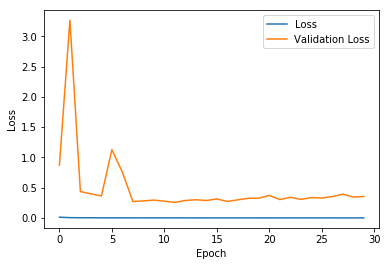

In [16]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [15]:
weight_dict = torch.load(checkpoint_path+'/epoch-5.pt')

In [16]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

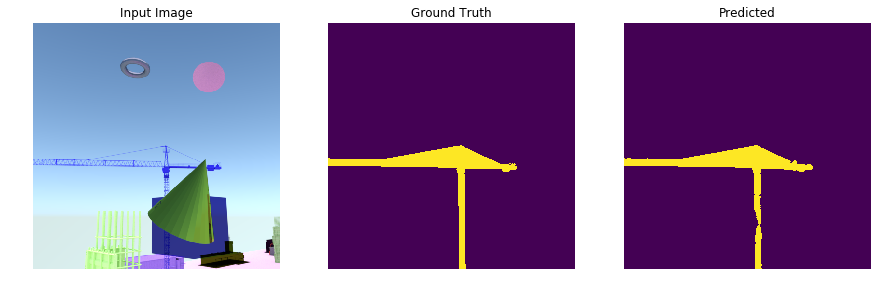

In [31]:
test_path = 'C:\\Users\\IVCL\\Desktop\\dock5_DR\\dataset\\test\\camera40653.png'
target_path = 'C:\\Users\\IVCL\\Desktop\\dock5_DR\\classify_occlusionX_semantic\\camera40653.png'
visualization(model, test_path, target_path)

In [28]:
def test_real(test_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).view(1,3,512,512)
    result = model(image)
    result = result.to('cpu').detach().numpy()
    result = np.where(result[0,:,:,:]>=0.5, 1.0, 0)

    test_image = plt.imread(test_path)

    plt.figure(figsize=(10,10))
    display_list = [test_image, result[0,:,:]]
    title = ['Input Image', 'Predicted']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

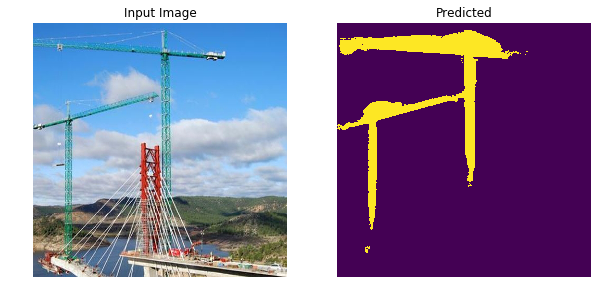

In [34]:
test_path = 'C:\\Users\\IVCL\\Desktop\\TC_Real_512\\0265.jpg'
test_real(test_path)